In [1]:
!pip install langgraph langsmith langchain langchain_groq langchain_community

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
from typing import Annotated
from typing_extensions import TypedDict

In [3]:
!pip install arxiv wikipedia

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [4]:
## Working With Tools

from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun

## Arxiv And Wikipedia tools
arxiv_wrapper=ArxivAPIWrapper(top_k_results=1,doc_content_chars_max=300)
arxiv_tool=ArxivQueryRun(api_wrapper=arxiv_wrapper)

api_wrapper=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=300)
wiki_tool=WikipediaQueryRun(api_wrapper=api_wrapper)

In [5]:
wiki_tool.invoke("who is Sharukh Khan")

'Page: Shah Rukh Khan\nSummary: Shah Rukh Khan (pronounced [ˈʃaːɦɾʊx xäːn] ; born 2 November 1965), also known by the initialism SRK, is an Indian actor and film producer who works in Hindi cinema. Referred to in the media as the "Baadshah of Bollywood" and "King Khan", he has appeared in more than 10'

In [6]:
arxiv_tool.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with "

In [7]:
tools=[wiki_tool]

In [8]:
## Langgraph Application
from langgraph.graph.message import add_messages
class State(TypedDict):
  messages:Annotated[list,add_messages]

In [9]:
from langgraph.graph import StateGraph,START,END

In [10]:
graph_builder= StateGraph(State)


In [11]:
from langchain_groq import ChatGroq

In [12]:
import os
from langchain_groq import ChatGroq
from dotenv import load_dotenv

load_dotenv()

groq_api_key = os.getenv("GROQ_API_KEY")  # Ensure this is a string


In [13]:
llm = ChatGroq(api_key=groq_api_key, model_name="deepseek-r1-distill-llama-70b")

# print(llm)
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7d59ecce56c0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7d59ecb14850>, model_name='deepseek-r1-distill-llama-70b', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [14]:
llm_with_tools=llm.bind_tools(tools=tools)

In [15]:
def chatbot(state:State):
  return {"messages":[llm_with_tools.invoke(state["messages"])]}

In [16]:
from langgraph.prebuilt import ToolNode,tools_condition

In [17]:
graph_builder.add_node("chatbot",chatbot)
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START,"chatbot")


In [18]:
graph=graph_builder.compile()

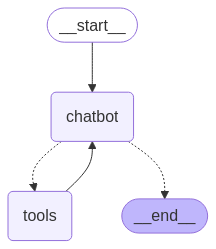

In [19]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [20]:
user_input="Hi there!, My name is John"

events=graph.stream(
     {"messages": [("user", user_input)]},stream_mode="values"
)

for event in events:
  event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there!, My name is John
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_kfh2)
 Call ID: call_kfh2
  Args:
    query: Artificial Intelligence
================================= Tool Message =================================
Name: wikipedia

Page: Artificial intelligence
Summary: Artificial intelligence (AI) refers to the capability of computational systems to perform tasks typically associated with human intelligence, such as learning, reasoning, problem-solving, perception, and decision-making. It is a field of research in computer sc
================================== Ai Message ==================================


In [21]:
user_input = "what is RLHF."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]},stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

what is RLHF.
================================== Ai Message ==================================

RLHF stands for "Real-time Load Handling" or "Real-time Load Handling Framework." It refers to a system or framework designed to manage and handle real-time loads efficiently, typically in distributed systems or cloud computing.


In [ ]:
# Import required modules
from langchain_core.messages import AIMessage, HumanMessage

# Initialize chat history
chat_history = []

# Start the chat loop
while True:
    user_input = input("You: ")  # Take user input

    if user_input.lower() in ["exit", "quit", "bye", "q"]:
        print("Chatbot: Goodbye!")
        break  # Exit the loop if the user wants to quit

    # Append the user's message to the chat history
    chat_history.append(HumanMessage(user_input))

    # Generate a response
    events = graph.stream({"messages": chat_history}, stream_mode="values")

    # Print the AI's response
    for event in events:
        ai_message = event["messages"][-1]
        ai_message.pretty_print()  # Pretty print the AI's response
        chat_history.append(AIMessage(ai_message.content))  # Append AI response to history


================================ Human Message =================================


================================== Ai Message ==================================

Sure! Let me explain the tools available for you to use in your applications. Currently, I have a tool named "wikipedia" which is a wrapper around Wikipedia. This tool is particularly useful when you need to answer general knowledge questions about people, places, companies, facts, historical events, or other subjects. To use this tool, you would call the function and provide a query parameter. For example, if you want to look up information about "Albert Einstein", you would structure your call like this: `{"function": "wikipedia", "arguments": {"query": "Albert Einstein"}}` This way, the tool will fetch the relevant information from Wikipedia. Each function call should be formatted within `<tool_call>` tags, specifying the function name and the arguments as a JSON object. Let me know if you need more details on how to int